# Tutorial: Running DePART within Python for RT prediction #

DePART was developed for the prediction of "retention times" from hSAX chromatography. However, the feature set and neural net can easily be transformed for RP prediction.

In this tutorial we will cover the basic steps for RP RT prediction.

In [8]:
#necessary imports
import DePART.preprocessing.FeatureFactory as FF
import DePART.preprocessing.PrepFactory as PF
import DePART.reader.ReaderFactory as RF
import DePART.learning.models as LM
import DePART.learning.processing as LP

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, auc, mean_squared_error, r2_score, f1_score, accuracy_score

from pyteomics import achrom
import numpy as np
import os
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import np_utils

#set a seed
np.random.seed(42)

## 1. Getting data from MaxQuant 

In [2]:
#options
min_obs = 300
infile = "C:\\Users\\hanjo\\ML\\DePART_New\\data\\evidence_SAX_Trost.txt"
df_evidence = RF.MaxQuant_Reader(infile)
print (df_evidence.shape)

#select most intense
df_filter = PF.filter_low_int_ids(df_evidence)

#minimum obs filter per fraction
df_filter = PF.filter_obs(df_filter, min_obs=min_obs)

#get a minimal df for processing
df_meta, df = PF.to_minimal_df(df_filter)

(337832, 60)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


NRows BEFORE min obs filter: 59723
NRows AFTER min obs filter: 59297


## 2. Generating the default list of features used by DePART

In [4]:
#generate features
Generator = FF.FeatureGenerator()
ff_df = Generator.create_all_features(df)


C:\ProgramData\Anaconda3\lib\site-packages\DePART\preprocessing\FeatureFactory.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["Sequence"] = df["Sequence"].apply(simply_alphabet).values
C:\ProgramData\Anaconda3\lib\site-packages\DePART\preprocessing\FeatureFactory.py:503: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  count_df.set_value(ii, nterm, count_df.loc[ii][nterm]+1)
C:\ProgramData\Anaconda3\lib\site-packages\DePART\preprocessing\FeatureFactory.py:510: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  count_df.set_value(ii, cterm, count_df.loc[ii][cterm]+1)


## 3. Fitting the Feed Forward Neural Net (FNN) to the Training data

In [48]:
#setttings
batch_size = 256
epochs = 75
nn_args = {"act":["swish", "swish", "relu"]}
###############################

#overwrite default column for predictor
ff_df["Fraction"] = df_meta["Retention time"]

#train and test split
train_df, valid_df = np.split(ff_df.sample(frac=1, random_state=42), 
                              [int(.75*len(ff_df))])

#format the dataframe for ML 
X_train_full, Seqs_train_full, y_train_full = LP.process_df(train_df)
X_valid_full, Seqs_valid_full, y_valid_full = LP.process_df(valid_df)    

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train_full)

#output dims depending on the number of fractions
output_dims = len(np.unique(train_df.Fraction))
input_dims = X_train_full.shape[1]

nnmodel = LM.FNN_Regressor(input_dim=input_dims, output_dim=1, loss="mse",**nn_args)
print (nnmodel.summary())
history = nnmodel.fit(np.array(X_train_full),
                      y_train_full,
                      epochs=epochs, batch_size=batch_size)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 50)                10750     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 40)                2040      
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 35)                1435      
_________________________________________________________________
dropout_18 (Dropout)         (None, 35)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 36        
Total para

44472/44472 [==============================] - 1s 20us/step - loss: 28535.3649 - mean_squared_error: 28535.3649
Epoch 57/150
44472/44472 [==============================] - 1s 19us/step - loss: 28535.3648 - mean_squared_error: 28535.3648
Epoch 58/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3646 - mean_squared_error: 28535.3646
Epoch 59/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3647 - mean_squared_error: 28535.3647
Epoch 60/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3646 - mean_squared_error: 28535.3646
Epoch 61/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3648 - mean_squared_error: 28535.3648
Epoch 62/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3647 - mean_squared_error: 28535.3647
Epoch 63/150
44472/44472 [==============================] - 1s 22us/step - loss: 28535.3648 - mean_squared_error: 28535.3648
Epoch 64/150


44472/44472 [==============================] - 1s 19us/step - loss: 28535.3646 - mean_squared_error: 28535.3646
Epoch 122/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3647 - mean_squared_error: 28535.3647
Epoch 123/150
44472/44472 [==============================] - 1s 19us/step - loss: 28535.3647 - mean_squared_error: 28535.3647
Epoch 124/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3646 - mean_squared_error: 28535.3646
Epoch 125/150
44472/44472 [==============================] - 1s 19us/step - loss: 28535.3648 - mean_squared_error: 28535.3648
Epoch 126/150
44472/44472 [==============================] - 1s 19us/step - loss: 28535.3646 - mean_squared_error: 28535.3646
Epoch 127/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3648 - mean_squared_error: 28535.3648
Epoch 128/150
44472/44472 [==============================] - 1s 20us/step - loss: 28535.3646 - mean_squared_error: 28535.3646
Epoch 

Here we compare the neural network model with a simple linear regression model (as used and implemented in pyteomics).

In [49]:
#pyteomics comparison
#Seqs_train_full.head()
RCs = achrom.get_RCs(Seqs_train_full, y_train_full)
RThat_train_pyt = np.array([achrom.calculate_RT(i, RCs) for i in Seqs_train_full])
RThat_valid_pyt = np.array([achrom.calculate_RT(i, RCs) for i in Seqs_valid_full])

print ("Pyteomics MSE (train): {:.2f}".format(mean_squared_error(y_train_full, RThat_train_pyt)))
print ("Pyteomics MSE (valid): {:.2f}".format(mean_squared_error(y_valid_full, RThat_valid_pyt)))

C:\ProgramData\Anaconda3\lib\site-packages\pyteomics\achrom.py:440: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.array(RTs))


Pyteomics MSE (train): 1071.47
Pyteomics MSE (valid): 1021.61


In [50]:
#neural network metrics
RThat_train_dep = np.ravel(nnmodel.predict(X_train_full))
RThat_valid_dep = np.ravel(nnmodel.predict(X_valid_full))
print ("DePART MSE (train): {:.2f}".format(mean_squared_error(y_train_full, RThat_train_dep)))
print ("DePART MSE (valid): {:.2f}".format(mean_squared_error(y_valid_full, RThat_valid_dep)))

DePART MSE (train): 28535.36
DePART MSE (valid): 28703.25


The results look in favor of DePART. Lets visualize the predictions.

Pyteomics Model


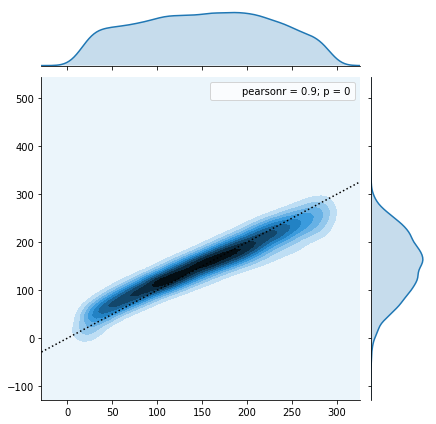

Neural Network


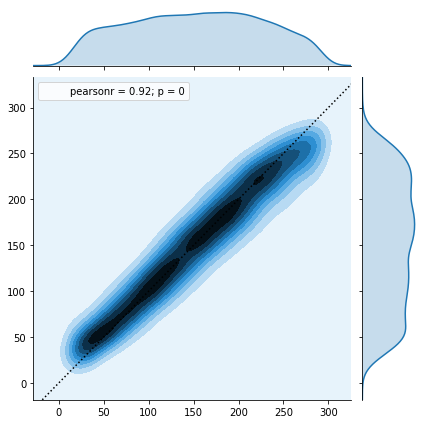

In [46]:
plt.clf()

print ("Pyteomics Model")
g = sns.jointplot(y_valid_full.values, RThat_valid_pyt, kind="kde")
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')    
plt.show()

print ("Neural Network")
g = sns.jointplot(y_valid_full.values, RThat_valid_dep, kind="kde")
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')    
plt.show()

As the MSE indicates both methods are fairly accurate in predicting RT on the validation data.

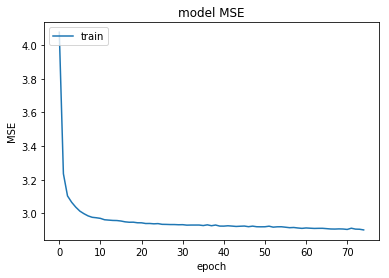

In [47]:
# we can also plot the history of the epochs along with the error metric (here, accuracy)
#compute some metrics
#is worth running more epochs?
plt.plot(np.log10(history.history['mean_squared_error']))
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

dict_keys(['loss', 'mean_squared_error'])
